In [1]:
#Install packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import kstest
import random
import matplotlib.ticker as ticker
import sys
import seaborn as sns

In [2]:
#MND survery: How long from GP to neurologist?
nsim = 100000
a = np.arange(0, nsim, 1)
t = np.zeros_like(a)

for i in a: 
    ran = random.uniform(0, 1)
    if 0 <= ran <= 0.17:
        t[i] = random.uniform(14,30)
    elif 0.17 <= ran <= 0.47:
        t[i] = random.uniform(31,90)
    elif 0.47 <= ran <= 0.63:
        t[i] = random.uniform(91,180)
    elif 0.63 <= ran <= 0.77:
        t[i] = random.uniform(181,270)
    elif 0.77 <= ran <= 0.83:
        t[i] = random.uniform(271,365)
    elif 0.83 <= ran <= 0.92:
        t[i] = random.uniform(366,730)
    elif 0.92 <= ran <= 1:
        t[i] = random.uniform(731,1000)  
        
#plt.hist(t, bins = 50)
#plt.xlabel('Number of days from GP to neurologist')

gp2referral_mean = np.mean(t)
gp2referral_std = np.std(t)

gp2referral_shape = scipy.stats.gamma.fit(t)[0]
gp2referral_loc = scipy.stats.gamma.fit(t)[1]
gp2referral_scale = scipy.stats.gamma.fit(t)[2]

In [3]:
#MND survery: How long from neurologist to diagnosis?
nsim = 10
a = np.arange(0, nsim, 1)
t = np.zeros_like(a)

for i in a: 
    ran = random.uniform(0, 1)
    if 0 <= ran <= 0.2:
        t[i] = random.uniform(14,30)
    elif 0.2 <= ran <= 0.43:
        t[i] = random.uniform(31,90)
    elif 0.43 <= ran <= 0.58:
        t[i] = random.uniform(91,180)
    elif 0.58 <= ran <= 0.68:
        t[i] = random.uniform(181,270)
    elif 0.68 <= ran <= 0.76:
        t[i] = random.uniform(271,365)
    elif 0.76 <= ran <= 0.87:
        t[i] = random.uniform(366,730)
    elif 0.87 <= ran <= 1:
        t[i] = random.uniform(731,1000)
        
#plt.hist(t, bins = 50)
#plt.xlabel('Number of days from neurologist to diagnosis')

neuro2diagnosis_mean = np.mean(t)
neuro2diagnosis_std = np.std(t)

neuro2diagnosis_shape = scipy.stats.gamma.fit(t)[0]
neuro2diagnosis_loc = scipy.stats.gamma.fit(t)[1]
neuro2diagnosis_scale = scipy.stats.gamma.fit(t)[2]

In [20]:
#Model variables 
'''

 UNITS ARE IN DAYS

    Args:
        s2gp (1x3 array): mean, SD and min time taken from symptom onset to presentation to first medical contact
        delay (1x3 array): mean, SD and min time delay in presentation
        refdelay (1x3 array): mean, SD and min time delay after referral to other
        gp2neuro (1x3 array): mean, SD and min time taken from gp to neurology appointment
        gp2other (1x3 array): mean, SD and min time taken from gp to other, non-neuro (ortho, ENT etc) appointment
        neuro2diagnosis (1x3 array): mean, SD and min time taken from neurology appointment to diagnosis
        nsim (scalar value): number of simulations to run
        p1 (scalar value): value between 0 and 1 - the probability that patient goes to GP when they have symptoms
        p2 (1x3 array): value between 0 and 1 - the probability that patient is correctly referred to neurologist,
        non-neurologist or not referred at all (should sum to 1)
        threshold (scalar): proportion of people are seen in 'threshold' amount of time
        survival (1x2 array): median number of days from symptom onset to death for ALS and bulbar
        covid_factor (scalar): factor by which times are increased by
        covid1_prob_p1 = probability that patient sees GP 
        covid1_prob_p2 = probability that GP refers patient
''' 

#Pre-COVID
s2gp = [150,180,14]
delay = [14,14,1]
refdelay = [45,45,14]
gp2neuro = [gp2referral_mean, gp2referral_std, gp2referral_loc]
neuro2diagnosis = [neuro2diagnosis_mean, neuro2diagnosis_std, neuro2diagnosis_loc]
nsim = 100000
p1 = 0.9 
p2 = 0.9
threshold = 365
survival = [879,690,1733]

covid_factor = 1.5 #Increase by 50%

#COVID probabilities at peak, no change in time
covid1_prob_p1 = 0.5
covid1_prob_p2 = 0.5

#COVID primary care increase by COVID factor
covid_s2gp = [i * covid_factor for i in s2gp]
covid_delay = [i * covid_factor for i in delay]

#COVID secondary care increase by COVID factor
covid_refdelay = [i * covid_factor for i in refdelay]
covid_gp2neuro = [i * covid_factor for i in gp2neuro]
covid_neuro2diagnosis = [i * covid_factor for i in neuro2diagnosis]

In [21]:
#SECOND MODEL - no GP2other, uses GP2referral as GP2referral encompassess time taken to see neurologist,
#irrespective of number of people seen on the way.
def pathway_simulation2(s2gp, gpdelay, refdelay, gp2neuro, neuro2diagnosis, nsim, p1, p2, threshold, survival):
    '''
    #Setting up the distributions for each step. We can change the distribution type, mean and SD. The references
    #will dictate what the distributions, mean, SD etc are. 

# UNITS ARE IN DAYS

    Args:
        s2gp (1x3 array): mean, SD and min time taken from symptom onset to presentation to first medical contact
        gpdelay (1x3 array): mean, SD and min time delay in presentation
        refdelay (1x3 array): mean, SD and min time delay after referral to other
        gp2neuro (1x3 array): mean, SD and min time taken from gp to neurology appointment, including referrals
        to other specialties
        neuro2diagnosis (1x3 array): mean, SD and min time taken from neurology appointment to diagnosis
        p1 (scalar value): value between 0 and 1 - the probability that patient goes to GP when they have symptoms
        p2 (scalar value): value between 0 and 1 - the probability that patient referred
        nsim (scalar): number of simulation in Monte Carlo simulation
        threshold (scalar): proportion of people are seen in 'threshold' amount of time
        survival (scalar): median number of days from symptom onset to death

    '''    

    #Number of simulations
    number_of_simulations = nsim
    
    # Set up probability distribution
    #Loc sets the minimum of the distribution
    #Shape (alpha) = (mean/SD)**2
    #Scale (beta) = (SD**2)/mean
    symptom_to_gp = gamma(a = (s2gp[0]/s2gp[1])**2, loc = s2gp[2], scale = (s2gp[1]**2)/s2gp[0])
    gp_delay_period = gamma(a = (gpdelay[0]/gpdelay[1])**2, loc = gpdelay[2], scale = (gpdelay[1]**2)/gpdelay[0])
    referral_delay_period = gamma(a = (refdelay[0]/refdelay[1])**2, loc = refdelay[2], scale = (refdelay[1]**2)/refdelay[0]) 
    
    if not gp2neuro:
        gp_to_neuro = gamma(a = gp2referral_shape, loc = gp2referral_loc, scale = gp2referral_scale)
    else:
        gp_to_neuro = gamma(a = (gp2neuro[0]/gp2neuro[1])**2, loc = gp2neuro[2], scale = (gp2neuro[1]**2)/gp2neuro[0])
    
    if not neuro2diagnosis:
        neuro_to_diagnosis = gamma(a = neuro2diagnosis_shape, loc = neuro2diagnosis_loc, scale = neuro2diagnosis_scale)
    else:
        neuro_to_diagnosis = gamma(a = (neuro2diagnosis[0]/neuro2diagnosis[1])**2, loc = neuro2diagnosis[2], scale = (neuro2diagnosis[1]**2)/neuro2diagnosis[0])
    
    
    t = np.arange(0, nsim, 1)
    s2gp_times = np.zeros_like(t)
    gpdelay_times = np.zeros_like(t)
    refdelay_times = np.zeros_like(t)
    gp2neuro_times = np.zeros_like(t)
    neuro2diagnosis_times = np.zeros_like(t)
    total_time = np.zeros_like(t)

    #Simulate the pathway
    for i in t:
    #Generate random number between 0 and 1. Use this number to dictate if patient goes from GP to neuro or other.
        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        return_to_gp = 0
        referral_delay_times = 0
    
    #Symptom onset to GP appointment
        if r1 <= p1: #p1 of people with MND will do straight to the GP
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = 0
        else: 
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = gp_delay_period.rvs()
            
    #GP to referral
        while r2 >= p2:
            referral_delay_times = referral_delay_period.rvs()  #then have a delay before going back to the GP
            r2 = random.uniform(0, 1) #pick a new random number for r2
        else: 
            gp_to_neuro_times = gp_to_neuro.rvs() #sample from gp2neuro
            
    #Neurology appointment to diagnosis              
        neuro_to_diagnosis_times = neuro_to_diagnosis.rvs()

    #Overall equation for calculating the total time to diagnosis
        s2gp_times[i] = symptom_to_gp_times
        gpdelay_times[i] = gp_delay_times
        refdelay_times[i] = referral_delay_times
        gp2neuro_times[i] = gp_to_neuro_times
        neuro2diagnosis_times[i] = neuro_to_diagnosis_times
        total_time[i] = symptom_to_gp_times + gp_delay_times + referral_delay_times + gp_to_neuro_times + neuro_to_diagnosis_times
    
    ''''
    #Plotting the overall distribution of times taken to go through the clinical pathway
    nbins = 50
    
    fig = plt.figure(figsize=(20,10))
    plt.style.use('seaborn-pastel')
    grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[1, 0])
    ax4 = fig.add_subplot(grid[1, 1]);

    #Set up axes
    #ax1.hist(total_time, nbins)
    sns.ecdfplot(total_time, ax=ax1)
    #ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(total_time)))
    ax1.set_xlim([0, 1500])
    
    #ax2.hist(s2gp_times, nbins)
    sns.ecdfplot(s2gp_times, ax=ax2)
    #ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(s2gp_times)))
    ax2.set_xlim([0, 500])
    
    #ax3.hist(gp2neuro_times, nbins)
    sns.ecdfplot(gp2neuro_times, ax=ax3)
    ax3.set_xlim([0, 400])
    #ax3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(gp2neuro_times)))
    
    #ax5.hist(neuro2diagnosis_times, nbins)
    sns.ecdfplot(neuro2diagnosis_times, ax=ax4)
    #ax5.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(neuro2diagnosis_times)))
    ax4.set_xlim([0, 1000])
    
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Proportion of people')
    ax1.set_title('Total time from symptom onset to diagnosis')
    ax2.set_title('Symptom onset to GP')
    ax3.set_title('GP to Neurology referral')
    ax4.set_title('Neurology appointment to diagnosis')
    '''
    
    #Print valuable information
    print("Proportion of people diagnosed before threshold =",np.mean(total_time < threshold))
    print("Proportion of ALS presenting as emergencies =",np.mean(total_time > survival[0]))
    print("Proportion of bulbar presenting as emergencies =",np.mean(total_time > survival[1]))
    print("Proportion of limb presenting as emergencies =",np.mean(total_time > survival[2]))
    print("Mean time =",np.mean(total_time))
    print("Median time =",np.median(total_time))
    print("Min time =",np.min(total_time))
    
    print("Symptom to GP time =",np.mean(s2gp_times))
    print("GP delay time =",np.mean(gpdelay_times))
    print("Referral delay time =",np.mean(refdelay_times))
    print("GP to neurologist time ="np.mean(gp2neuro_times))
    print("Neurologist to diagnosis time ="np.mean(neuro2diagnosis_times))
    
    return total_time, s2gp_times, gp2neuro_times, neuro2diagnosis_times

In [22]:
#Pre-COVID model
preCOVID = pathway_simulation2(s2gp, delay, refdelay, [] , [], nsim = nsim, p1 = p1, p2 = p2, threshold = 365, survival = [879,690,1733])

Proportion of people diagnosed before threshold = 0.44529
Proportion of ALS presenting as emergencies = 0.1025
Proportion of bulbar presenting as emergencies = 0.19867
Proportion of limb presenting as emergencies = 0.00416
Mean time = 473.85472
Median time = 401.0
Min time = 47
163.91155
1.4316
5.79911
191.91089
109.73646


In [23]:
#COVID model - primary care only
COVID_primary = pathway_simulation2(covid_s2gp, covid_delay, refdelay, gp2neuro, neuro2diagnosis, nsim = nsim, p1 = covid1_prob_p1, p2 = covid1_prob_p2, threshold = 365, survival = survival)

Proportion of people diagnosed before threshold = 0.22059
Proportion of ALS presenting as emergencies = 0.28125
Proportion of bulbar presenting as emergencies = 0.42925
Proportion of limb presenting as emergencies = 0.03293
Mean time = 713.67375
Median time = 615.0
Min time = 59
246.56543
11.07491
29.00363
226.12319
199.42258


In [24]:
#COVID model - secondary care only
COVID_secondary = pathway_simulation2(s2gp, delay, covid_refdelay, covid_gp2neuro, covid_neuro2diagnosis, nsim = nsim, p1 = covid1_prob_p1, p2 = covid1_prob_p2, threshold = 365, survival = survival)

Proportion of people diagnosed before threshold = 0.16151
Proportion of ALS presenting as emergencies = 0.38297
Proportion of bulbar presenting as emergencies = 0.52919
Proportion of limb presenting as emergencies = 0.07427
Mean time = 855.96905
Median time = 724.0
Min time = 67
164.12043
7.29367
44.14002
338.05007
300.86957


In [25]:
#COVID model - all proccesses lengthened
COVID_all = pathway_simulation2(covid_s2gp, covid_delay, covid_refdelay, covid_gp2neuro, covid_neuro2diagnosis, nsim = nsim, p1 = covid1_prob_p1, p2 = covid1_prob_p2, threshold = 365, survival = survival)

Proportion of people diagnosed before threshold = 0.12388
Proportion of ALS presenting as emergencies = 0.44859
Proportion of bulbar presenting as emergencies = 0.5962
Proportion of limb presenting as emergencies = 0.09865
Mean time = 942.8775
Median time = 810.0
Min time = 76
245.35425
11.03948
44.33691
339.85809
300.78709


Text(0.5, 1.0, 'Neurology appointment to diagnosis')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


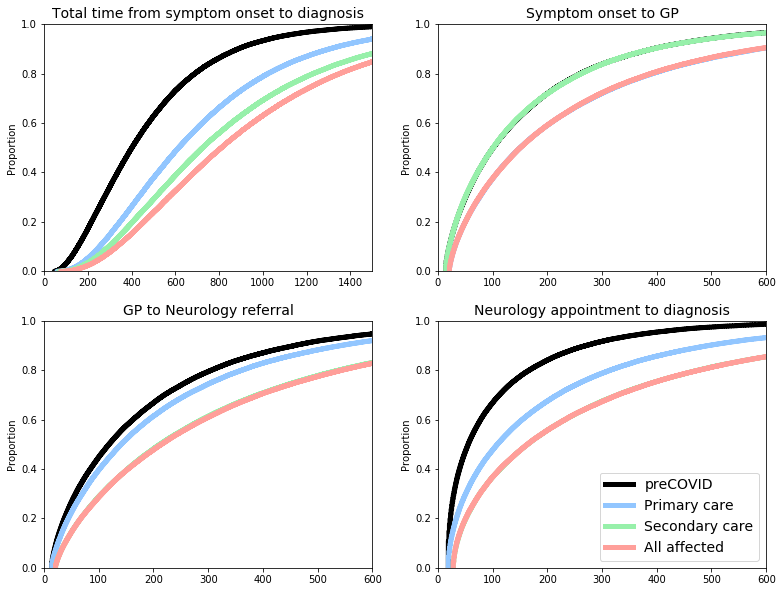

In [26]:
#Plotting the overall distribution of times taken to go through the clinical pathway
lw = 5 #linewidth
    
fig = plt.figure(figsize=(20,10))
plt.style.use('seaborn-pastel')
grid = plt.GridSpec(2, 3, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1]);

#Set up axes
sns.ecdfplot(preCOVID[0], label = 'preCOVID', linewidth = lw, color = 'k', ax=ax1)
sns.ecdfplot(COVID_primary[0], label = 'Primary care', linewidth = lw, ax=ax1)
sns.ecdfplot(COVID_secondary[0], label = 'Secondary care', linewidth = lw, ax=ax1)
sns.ecdfplot(COVID_all[0], label = 'All affected', linewidth = lw, ax=ax1)
ax1.set_xlim([0, 1500])

sns.ecdfplot(preCOVID[1], label = 'preCOVID', linewidth = lw, color = 'k', ax=ax2)
sns.ecdfplot(COVID_primary[1], label = 'Primary care', linewidth = lw, ax=ax2)
sns.ecdfplot(COVID_secondary[1], label = 'Secondary care', linewidth = lw, ax=ax2)
sns.ecdfplot(COVID_all[1], label = 'All affected', linewidth = lw, ax=ax2)
ax2.set_xlim([0, 600])

sns.ecdfplot(preCOVID[2], label = 'preCOVID', linewidth = lw, color = 'k', ax=ax3)
sns.ecdfplot(COVID_primary[2], label = 'Primary care', linewidth = lw, ax=ax3)
sns.ecdfplot(COVID_secondary[2], label = 'Secondary care', linewidth = lw, ax=ax3)
sns.ecdfplot(COVID_all[2], label = 'All affected', linewidth = lw, ax=ax3)
ax3.set_xlim([0, 600])

sns.ecdfplot(preCOVID[3], label = 'preCOVID', linewidth = lw, color = 'k', ax=ax4)
sns.ecdfplot(COVID_primary[3], label = 'Primary care', linewidth = lw, ax=ax4)
sns.ecdfplot(COVID_secondary[3], label = 'Secondary care', linewidth = lw, ax=ax4)
sns.ecdfplot(COVID_all[3], label = 'All affected', linewidth = lw, ax=ax4)
ax4.set_xlim([0, 600])

fsize = 14 #font size of labels
tsize = 14 #font size of titles

plt.legend(prop=dict(size=14))
ax1.set_title('Total time from symptom onset to diagnosis', size=tsize)
ax2.set_title('Symptom onset to GP', size=tsize)
ax3.set_title('GP to Neurology referral', size=tsize)
ax4.set_title('Neurology appointment to diagnosis', size=tsize)